# Levy-Lieb Procedure for Variational Quantum Eigensolvers - The Hubbard Dimer

In this notebook, we will calculate the ground state of a Hubbard dimer using the Levy-Lieb procedure. First consider an interacting-particle system described by the Hamiltonian,
\begin{equation*}
\hat{H} = \hat{T} + \hat{W} + \hat{v}
\end{equation*}

where $\hat{T}$, $\hat{W}$ are the kinetic and interaction potential operators and $\hat{v}$ is the external potential operator. The Levy-Lieb procedure relies on the the Levy-Lieb density functional which is evaluated by minimizing the expectation:

\begin{equation*}
F_{LL}(t) = \langle \psi(t) | \hat{T} + \hat{W} | \psi(t) \rangle
\end{equation*}

Subject to the constraint 
\begin{equation*}
\|d\| \equiv \| \langle \Psi(t) | \hat{\mathbf{D}} | \Psi(t) \rangle\ \|  = 0
\end{equation*}

where  
\begin{equation*}
\mathbf{\hat{D}} \equiv \left[ \sum_{\sigma} \hat{c}^\dagger_{i\sigma} \hat{c}_{i\sigma} - n_i, \quad i = 1..M \right]
\end{equation*}

where $M$ is the size of the system. The value of $\mathbf{n}$ is varied to minimise $F_{LL} (\mathbf{v}) + \mathbf{v} . \mathbf{n}$ classically. At the optimum, $\mathbf{n}^{*}$, the ground state is simply
\begin{equation*}
E_{ground}( \mathbf{v}) = F_{LL} ( \mathbf{n}^{*}) + \mathbf{v} . \mathbf{n}^{*}
\end{equation*}

We follow closely the theory and reproduce results from Ref. 1.

___________________________________________________________________________________________________________________________________________________________




In [367]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import matplotlib.pylab as plt

from qiskit import QuantumCircuit, transpile, execute
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Statevector, SparsePauliOp
import qiskit_aer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_algorithms import VQE, estimate_observables
from qiskit_algorithms.optimizers import SLSQP

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

The Hubbard Dimer is defined by the following Hamiltonian:
\begin{equation*}
\hat{H} = -t \sum_{\sigma=\uparrow,\downarrow} (c^\dagger_{1\sigma} c_{2\sigma} + \text{h.c.}) + U \sum_{i} \hat{n}_{i\uparrow} \hat{n}_{i\downarrow} + \sum_{i} v_i (\hat{n}_{i\uparrow} + \hat{n}_{i\downarrow})
\end{equation*}


In [2]:
def hubbard_dimer_ham(t, u, dv):
    """
    Calculates the hamiltonian for a symmetric hubbard dimer
    Args:
        t (float): Kinetic energy parameter
        u (float): Interaction energy parameter.
        dv (float): Onsite, symmetric, potential energy difference
    Returns:
        FermionicOp
    """
    # Define the potential energy terms for the symmetric dimer
    v1 = -dv / 2  
    v2 = dv / 2

    # Kinetic Energy, T, Interaction Energy, W
    T = -t * (FermionicOp({f"+_3 -_2" : 1}, 4) + FermionicOp({f"+_2 -_3" : 1}, 4) + 
              FermionicOp({f"+_1 -_0" : 1}, 4) + FermionicOp({f"+_0 -_1" : 1}, 4))
    W = u * (FermionicOp({f"+_3 -_3 +_1 -_1" : 1}, 4) + FermionicOp({f"+_2 -_2 +_0 -_0" : 1}, 4))

    # Onsite potential energy terms
    V1 = v1 * (FermionicOp({f"+_3 -_3" : 1}, 4) + FermionicOp({f"+_1 -_1" : 1}, 4))
    V2 = v2 * (FermionicOp({f"+_2 -_2" : 1}, 4) + FermionicOp({f"+_0 -_0" : 1}, 4))
    return (T + W + V1 + V2).simplify()


We will use the Jordan Wigner Mapping which allows us to track site occupation of each orbital. In total in our system there are 4 spin-specific orbitals. It is convention in Qiskit that these orbitals are ordered by spin. Our mapping is as follows:

\begin{array}{ccccccc}
|0000 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \_ & \_  \\
|0001 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \_ & \text{Site 2:} & \_ & \_  \\
|0010 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \uparrow & \_  \\
|0100 \rangle & \Rightarrow & \text{Site 1:} & \_ & \downarrow & \text{Site 2:} & \_ & \_ & \\
|1000 \rangle & \Rightarrow & \text{Site 1:} & \_ & \_ & \text{Site 2:} & \_ & \downarrow \\
|0011 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \_ & \text{Site 2:} & \uparrow & \_  \\
|0101 \rangle & \Rightarrow & \text{Site 1:} & \uparrow & \downarrow & \text{Site 2:} & \_ & \_ \\
\end{array}

and so on...

We will now define the number operator which has the following property:

\begin{equation*}
\hat{c}^{\dagger}_{i\sigma} \hat{c}_{i\sigma} | \psi \rangle= \hat{n}_{i\sigma} | \psi \rangle = n_{i\sigma} | \psi \rangle
\end{equation*}

where $\sigma = \uparrow, \downarrow$. Therefore, we can track site occupation of certain spins by calculating the expectation value of the number operator. 


In [3]:
mapper = JordanWignerMapper()

def number(orbital):
    """Returns the number operator (SparsePauliOp) for a specified orbital (int)"""
    return mapper.map(FermionicOp({f"+_{orbital} -_{orbital}" : 1}, 4))


Our ansatz describes the functional form of the eigenstate we anticipate $ |\Psi(t) \rangle = U(t) \ |\Psi_{i}\rangle$.
The parameters $\mathbf{t}$ will be varied to minimize $\langle \Psi(t) | \hat{T} + \hat{W} | \Psi(t) \rangle$. (In code, the optimizer refers to the ansatz parameters as '$\mathbf{x}$'). The ansatz will use be using is the unitary coupled cluster with single and double excitations. It is in the ansatz, we describe some of the allowable conditions for our final state. i.e. the number of particles and whether or not spin is conserved. 

In [4]:
from qiskit import QuantumCircuit
from qiskit_nature.second_q.circuit.library import UCCSD

initial_state = QuantumCircuit(4)
initial_state.x([0, 3])    

# Define ansatz as UCC. Contains a series of gates of parameter t[i]. These parameters are optimised in the VQE program.
ansatz = UCCSD(num_spatial_orbitals = 2,              
               num_particles = [1, 1],                # One spin up, one spin down
               qubit_mapper = mapper,   
               preserve_spin = False,                 
               reps = 2,                              
               initial_state = initial_state 
              )

print('Our ansatz is as follows:')
ansatz.decompose().draw()

Our ansatz is as follows:


┌───┐┌───────────────────────────────┐┌───────────────────────────────┐»
q_0: ┤ X ├┤0                              ├┤0                              ├»
     └───┘│                               ││                               │»
q_1: ─────┤1                              ├┤1                              ├»
          │  exp(-it (IIXY + IIYX))(t[0]) ││  exp(-it (XZZY + YZZX))(t[1]) │»
q_2: ─────┤2                              ├┤2                              ├»
     ┌───┐│                               ││                               │»
q_3: ┤ X ├┤3                              ├┤3                              ├»
     └───┘└───────────────────────────────┘└───────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IXYI + IYXI))(t[2]) ││  exp(-it (XYII + YXII))(t[3]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                        ├»
«     │                                                                         │»
«q_1: ┤1                                                                        ├»
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[4]) │»
«q_2: ┤2                                                                        ├»
«     │                                                                         │»
«q_3: ┤3                                                                        ├»
«     └─────────────────────────────────────────────────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IIXY + IIYX))(t[5]) ││  exp(-it (XZZY + YZZX))(t[6]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌───────────────────────────────┐┌───────────────────────────────┐»
«q_0: ┤0                              ├┤0                              ├»
«     │                               ││                               │»
«q_1: ┤1                              ├┤1                              ├»
«     │  exp(-it (IXYI + IYXI))(t[7]) ││  exp(-it (XYII + YXII))(t[8]) │»
«q_2: ┤2                              ├┤2                              ├»
«     │                               ││                               │»
«q_3: ┤3                              ├┤3                              ├»
«     └───────────────────────────────┘└───────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                        ├
«     │                                                                         │
«q_1: ┤1                                                                        ├
«     │  exp(-it (YYXY + XYYY + XXXY + YXYY + XYXX + YYYX + YXXX + XXYX))(t[9]) │
«q_2: ┤2                                                                        ├
«     │                                                           

The ansatz however, does not constrain the solution to the corresponding domain of allowable densities. For instance, if we wish to calculate the Levy-Lieb functional for $\mathbf{n} = [0, 2]$, then clearly the energy associated with $|\Psi(t) \rangle = |0101 \rangle  \rightsquigarrow \mathbf{n} = [2, 0]$ is not an acceptable result. To ensure our minimisation process only returns eigenstates of allowable densities, we define the density difference operator
\begin{equation*}
\mathbf{\hat{D}} \equiv [\ \hat{n}_{1\uparrow} + \hat{n}_{1\downarrow} - n_1 \hat{I}, \ \ \ \hat{n}_{2\uparrow} + \hat{n}_{2\downarrow} - n_2 \hat{I} \ ]
\end{equation*}

whose expectation value is defined by the vector:
\begin{equation*}
\mathbf{d} \equiv \langle \Psi(t) | \mathbf{\hat{D}} | \Psi(t) \rangle\
\end{equation*}

We will constrain our VQE process such that $\| \mathbf{d}\| = 0$, which ensures that the optimisation process is limited to the space of allowable densities, $\mathcal{W}^{n}_{N}$.

Now, we define the Levy-Lieb functional, $F_{LL}$ as a function of first site occupation, $n_{1}$ and interaction potential, $U$. Our sub-routine to calculate $F_{LL}$ is obtained from Ref. 1 and is as follows:

$\rightarrow$ Step 1. Accept a vector of site occupations:
\begin{equation*}
    n \equiv [n_1, n_2] \quad \text{such that}\quad
    \begin{cases}
        0 < n_i < 2, \\
        n_1 + n_2 = 2.
    \end{cases}
\end{equation*}

 - Minimise $\langle \Psi(t) | \mathbf{\hat{D}} | \Psi(t) \rangle$ using the L-BFGS-B optimisation routine. At optimum, we have $|\Psi_{i} \rangle$ which exists approximately in the subspace of allowable wavefunctions, $\mathcal{W}^{n}_{N}$.

- Then set $|\Psi_{i} \rangle$ as the initial state for our VQE process.


$\rightarrow$ Step 2. Minimise $\langle \Psi(t)| \ \hat{T} + \hat{W} \ | \Psi(t) \rangle$ using the SLSQP optimiser subject to the constraint $\| \mathbf{d} \| = 0$. In this process, the parameters of the ansatz, $|\Psi(t) \rangle = U(t) |\Psi_{i} \rangle$ are varied until an optimum is reached.
   
- The minimum eigenvalue subject to these constraints yields $F_{LL}( \mathbf{n} )$. 

A convenient shortcut to this routine is to skip Step 1 entirely and set initial guess $|\Psi_{i} \rangle$ equal to the previously obtained ground state.

In [770]:
class Levy_Lieb:
    def __init__(self, U, ansatz):
        self.U = U
        self.x0 = None
        self.ansatz = ansatz


    def D(self, n1):
        """Density difference operator (list[SparsePauliOp])"""  
        D1 = number(0) + number(2) - SparsePauliOp(["IIII"], coeffs=[n1])
        D2 = number(1) + number(3) - SparsePauliOp(["IIII"], coeffs=[2 - n1])
        return [D1.simplify(), D2.simplify()]

    
    def abs_d(self, x, n1):
        """Calculates  ||d||: the absolute value of the expectation of D(n1)"""
        ket = self.state(x).data
        bra = np.conjugate(ket.T)
        d1 = np.real(bra @ self.D(n1)[0].to_matrix() @ ket)
        d2 = np.real(bra @ self.D(n1)[1].to_matrix() @ ket)
        return np.sqrt(d1**2 + d2**2)

    
    def state(self, x):
       """Returns Levy Lieb embedded state (Statevector)"""
       circ = self.ansatz.initial_state.copy()  
       reps = self.ansatz.reps
       ops = mapper.map(ansatz.excitation_ops())
       for i in range(reps):
           for j, op in enumerate(ops):
               ansatz_gate = PauliEvolutionGate(op, time = x[i * len(ops) + j])  # Input each value of x into each gate
               circ.append(ansatz_gate, range(self.ansatz.num_qubits))                
       return Statevector.from_instruction(circ)


    def density_constrained_VQE(self, x0, n1, t):
        """Performs VQE on operator, T + W, subject to density constraints
        Args:
            x0 (numpy.ndarray): initial ansatz parameters
            U (float): interaction energy parameter
        Returns:
            VQEResult"""
        T_W = mapper.map(hubbard_dimer_ham(t, self.U, 0))

        vqe = VQE(estimator=Estimator(),
              ansatz=ansatz,
              optimizer=SLSQP(constraints=[{'type':'eq', 'fun':self.abs_d, 'args':(n1,)}]),
              initial_point=x0,
             )
        return vqe.compute_minimum_eigenvalue(T_W)


    def functional(self, n1, t):
        """Computes the Levy-lieb functional and Levy-lieb embedded state
        Args:
            n1 (float, 0 < n1 < 2): first lattice site occupation
            U (float): interaction energy parameter
        Returns:
            float, Statevector"""
        if self.x0 is None:
            results = []  
            states = []
            for rep in range(2):
                ## Step 1. Minimise ||d|| to find initial guess for VQE
                min_d = minimize(fun=self.abs_d,
                            x0=[np.random.uniform(-10, 10) for _ in range(10)],
                            method='L-BFGS-B',  # Optimisation method
                            args=(n1,),
                            )
                self.x0 = min_d.x

                ## Step 2. Minimise T + W  subject to constraint that ||d|| = 0 
                res = self.density_constrained_VQE(self.x0, n1, t)
                results.append(res.eigenvalue)
                states.append(res.optimal_point)
            self.x0 = states[np.argmin(results)] # Store optimal point for next time
            return min(results), self.state(self.x0)

        else:                                                                            
            ## Skip to Step 2. Use optimum point from previous VQE as starting guess, x0
            VQE_result = self.density_constrained_VQE(self.x0, n1, t)
            self.x0 = VQE_result.optimal_point  # Store optimal point for next time
            return VQE_result.eigenvalue, self.state(self.x0)


    def kernel(self, t, n1, n2):
        """Returns the Levy-Lieb kernel matrix for input pairwise density datasets.
        Returns the Levy-Lieb kernel for input scalar values"""
        # If n1 is a scalar value, return a scalar value
        if np.isscalar(n1):
            x1 = self.functional(n1, t)[1]
            x2 = self.functional(n2, t)[1]
            ket = self.state(x1).data
            bra = np.conjugate(self.state(x2).data.T)
            return np.abs(ket @ bra) ** 2

        # If n1, n2 are pairwise datasets, create kernel matrix
        K_matrix = np.ones((len(n1), len(n2)))

        # Calculate Levy-Lieb embedded states for n1 data
        states1 = []
        self.x0 = None
        for n in n1:
            state1 = self.functional(n, t)[1]
            states1.append(state1)

        # Calculate Levy-Lieb embedded states for n2 data
        states2 = []
        self.x0 = None
        if np.array_equal(n1, n2):
            states2 = states1.copy()
        else:
            for n in n2:
                state2 = self.functional(n, t)[1]
                states2.append(state2)

        # Calculate kernel matrix
        for i in range(len(n1)):
            for j in range(len(n2)):
                if n1[i] != n2[j]:
                    state1 = states1[i]
                    state2 = states2[j]

                    ket = state1.data
                    bra = np.conjugate(np.transpose(state2.data))
                    K_matrix[i][j] = np.abs(ket @ bra) ** 2
        return K_matrix

We will cycle through the different values of $U$, and compile the calculated $F_{LL}$ for each value of $\mathbf{n}$.

In [13]:
U_list = [0, 0.2, 1, 2, 5, 10]
n_array = np.linspace(0, 1, 101)
functionals = []

for U in U_list:
    functionals_U = []
    Levy_Lieb_class = Levy_Lieb(U, ansatz)
    for n1 in n_array:
        FLL = Levy_Lieb_class.functional(n1=n1, t=0.5)
        functionals_U.append(FLL[0])
    functionals.append(functionals_U)

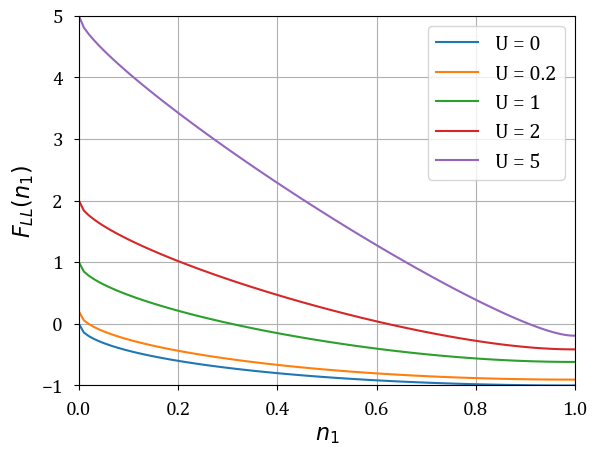

In [96]:
plt.rcParams['font.family'] = 'Cambria'
plt.xlim(0, 1)
plt.ylim(-1, 5)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 16})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 16})
plt.grid(True)
for i in range(len(U_list) - 1):
    plt.plot(n_array, functionals[i], label=f'U = {U_list[i]}')
plt.tick_params(axis='both', labelsize=14,  direction='out', pad=8)
plt.legend(prop={'size': 15})

Due to the symmetry of the lattice, the Levy-Lieb functional is symmetrical about $n_{1}$ = 1. To expand our data to $1 < n_{1} < 2$, we can take the mirror image of our obtained dataset.

Furthermore, for the sake of time, let's just interpolate the dataset and call the interpolated values when calling $F_{LL}(\mathbf{n})$ in future using ``scipy``.

In [97]:
total_n_array = np.linspace(0, 2, 201)
mirrored_functionals = [sublist + sublist[:-1][::-1] for sublist in functionals]

def interpolated_functional(n1, U):
    """ Interpolates the pre-generated Levy-Lieb values
    Args:
        n1 (float, 0 < n1 < 2): first lattice site occupation
        U (0, 0.2, 1, 2, 5, 10): interaction energy parameter
    Returns:
        float"""
    U_index = U_list.index(U)
    interpolated_functional = interp1d(total_n_array, mirrored_functionals[U_index],
                                       axis=-1, kind='cubic', fill_value='extrapolate')
    return interpolated_functional(n1)

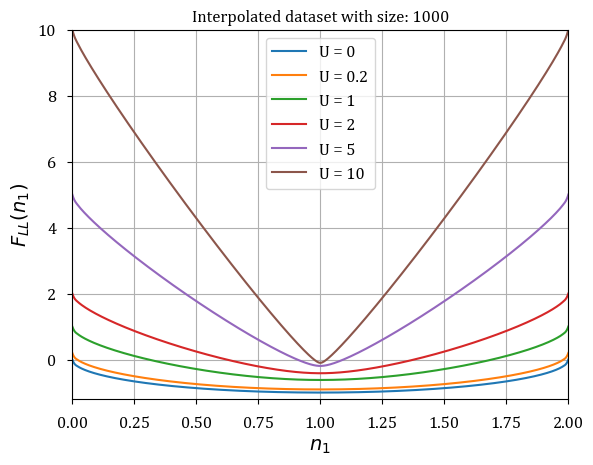

In [98]:
# Plot the new interpolated dataset
plt.title('Interpolated dataset with size: 1000')
plt.xlim(0, 2)
plt.ylim(-1.2, 10)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.grid(True)
for i in range(len(U_list)):
    plt.plot(np.linspace(0, 2, 1001), interpolated_functional(np.linspace(0, 2, 1001), U_list[i]), label=f"U = {U_list[i]}")
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
plt.legend(prop={'size': 12})

We now optimize $F_{LL}(\mathbf{n}) + \mathbf{v} \cdot \mathbf{n}$ subject to the constraint that $0 < n_{i} ≤ 2$ and $\sum_{i} n_{i} = 2$. 

In [99]:
def energy(n1, U, dv):
    """Calculates the expression, FLL(n) + v.n for a symmetric Hubbard dimer using interpolated functional.
    Args:
        n1 (float, 0 < n1 < 2): first lattice site occupation
        U (0, 0.2, 1, 2, 5, 10): interaction energy parameter
        dv (float): onsite, symmetric potential energy difference
    Returns:
        float"""
    #  Let the cite potentials be symmetrical
    v1 = -dv / 2
    v2 = dv / 2
    return interpolated_functional(n1, U) + n1 * v1  + (2 - n1) * v2


def ground_energy(U, dv):
    """Calculates the energy of the ground state by minimising the interpolated energy function 
    with respect to density using SLSQP.
    Args:
        U ([0, 0.2, 1, 2, 5, 10]): interaction energy parameter
        dv (float): onsite, symmetric potential energy difference
    Returns:
        float"""
    ## Step 1 - Find initial density guess for minimisation routine
    n_initial = 0                           
    E_initial = energy(n_initial, U, dv)

    # Briefly cycle through 13 values of n, compute energy and set initial guess at minimum
    for n1 in np.linspace(0.14, 2, 13):   
        E_guess = energy(n1, U, dv)        
        if E_guess < E_initial:
            E_initial = E_guess              
            n_initial = n1                 

    ## Step 2 - Minimise Energy function to find ground state 
    constraints = [{'type': 'ineq', 'fun': lambda x : 2 - x},  
                  {'type': 'ineq', 'fun': lambda x : x}]      

    min_E = minimize(fun=energy,                            
                     x0=n_initial,                             
                     args=(U, dv),
                     constraints=constraints,                
                     method='SLSQP', 
                    )
    return min_E.fun

In [100]:
# Calculate the ground energy for 40 values of dv, for each value of U
dv_array = np.arange(0, 20.5, 0.5)
energies = [[ground_energy(U, dv) for dv in dv_array] for U in U_list]

We will compare our results to that of the exact ground state. This can be calculated by calculating the eigenvalues of the matrix representation of the Hamiltonian in the basis set, $|1 ↑ 1 ↓ \rangle$, $|1 ↑ 2 ↓ \rangle$, $|1 ↓ 2 ↑ \rangle$, $|2 ↑ 2 ↓ \rangle$ [2]:

\begin{equation}
\hat{H} = \begin{bmatrix}
    2v_1 + U & -t & t & 0 \\
    -t & 0 & 0 & -t \\
    t & 0 & 0 & t \\
    0 & -t & t & 2v_2 + U
\end{bmatrix}
\end{equation}


In [101]:
def exact_ground_energy(t, U, dv):
    """Calculates the exact eigenvalues of the symmetric dimer"""
    # The Hamiltonian for a symmetric dimer. 
    v1, v2 = -dv/2, dv/2
    H = np.array([[2 * v1 + U, -t,       t,  0],
                  [-t,          0,       0, -t],
                  [t,           0,       0,  t],
                  [0,          -t,       t,  2 * v2 + U]])    
    
    eigenvalues = np.real(np.linalg.eig(H)[0]) 
    return min(eigenvalues)


# Calculate the exact ground state energies for a new array of potential differences, dv_array2
dv_array2 = np.arange(0, 20 + 0.5/6, 0.5/3)
exact_energies = [[exact_ground_energy(0.5, U_list[i], dv) for dv in dv_array2] 
                  for i in range(len(U_list))]

By calculating the exact ground state solutions, we will calculate the relative absolute error.

In [102]:
# Take the difference between exact Energy and calculated energy to calculate relative absolute error
errors = [[abs((exact_energies[i][j*3] - energies[i][j])) for j in range(len(energies[0]))] 
          for i in range(len(exact_energies))]

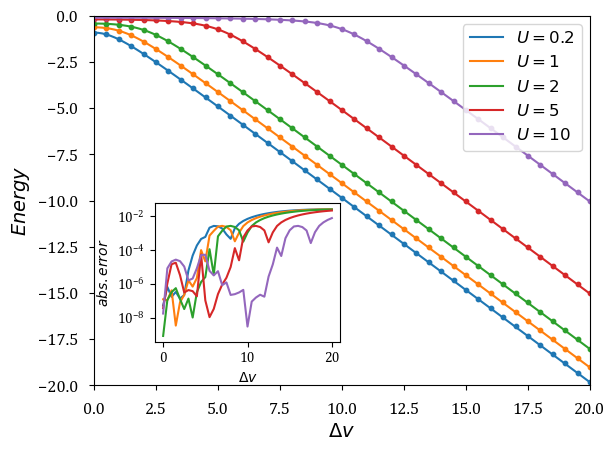

In [103]:
fig, ax_main = plt.subplots()
for i in range(1, len(energies)):
    ax_main.scatter(dv_array, energies[i], s = 10)
    ax_main.plot(dv_array2, exact_energies[i], label = f'$U = {U_list[i]}$')
plt.legend(loc = 1, prop = {'size':12})
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)
left, bottom, width, height = 0.22, 0.2, 0.29, 0.29
ax_small = fig.add_axes([left, bottom, width, height])
for i in range(1, len(errors)):
    ax_small.semilogy(dv_array, errors[i])
ax_small.set_xlabel(r'$\Delta v$')
ax_small.set_ylabel(r'$abs. error$')
ax_main.set_xlim(0, 20)
ax_main.set_ylim(-20, 0)
ax_main.set_xlabel(r'$\Delta v$',  fontdict={'fontsize': 14})
ax_main.set_ylabel(r'$Energy$',  fontdict={'fontsize': 14})
plt.show()

The relatively high error is likely due to our choice to interpolate the data as opposed to directly calling the Levy-lieb functional function in the energy minimisation process

-------------------------------------------------------------------------------------------------------------------------------------------------

## The Levy-Lieb quantum kernel

Now, we will define the Levy-Lieb quantum kernel:
\begin{equation*}
\kappa_{LL}(n_1, n_2) = || \langle \Psi_{LL}[n_1]  |  \Psi_{LL}[n_2] \rangle || ^{2}
\end{equation*}

A single entry in the kernel matrix is defined as $K_{i, j} = |\langle \Psi [\bm{n}_i] | \Psi [\bm{n}'_j] \rangle |^{2}$ where $\bm{n}$ and $\bm{n'}$ are pairwise density datasets. 

Let us generate the Levy-Lieb kernel for input dataset, ``n_array`` for each value of ``U``. We can then slice this array appropriately to generate training and test kernel matrices. We will store each kernel matrix in ``total_kernels_list``.

In [ ]:
U_list = [0, 0.2, 1, 2, 5]
n_array = np.linspace(0, 1, 101)

total_kernels_list = []

# Evaluate total Kernel for each value of U
for U in U_list:
    print('Current U:', U)
    Levy_Lieb_class = Levy_Lieb(U, ansatz)
    K_total = Levy_Lieb_class.kernel(0.5, n_array, n_array)
    total_kernels_list.append(K_total)

We will also define a function which generates the Gaussian kernel as a matrix. The Gaussian kernel is as follows:
\begin{equation*}
\kappa_G(n_1, n_2) = \exp(-\gamma ||n_1 - n_2||^2)
\end{equation*}

In [772]:
def kernel_gaussian(n_array1, n_array2, gamma):
    """Calculates the Gaussian kernel matrix from pariwise density datasets, n_array1, n_array2
    for a specified Gaussian hyperparameter, sigma"""
    K = np.ones((len(n_array1), len(n_array2)))
    for i in range(len(n_array1)):
        for j in range(len(n_array2)):
                K[i][j] = np.exp(-gamma * np.abs(n_array1[i] - n_array2[j])**2)
    return K

We can optimize our choice for $\sigma$ by maximising the kernel alignment defined by:
\begin{equation*}
A(K_{LL}, K_{G}) = \frac{tr(K_{LL} K_{G})}{ \sqrt{tr(K_{LL}^2) \ tr(K_{GG}^2)}}
\end{equation*}


In [773]:
def optimum_gamma(K_LevyLieb, n_train):
    """Calculates the optimum choice for Gaussian hyperparameter for training set and U
    by maximising the kernel alignment between the Levy-Lieb & Gaussian kernels."""
    def alignment(gamma):
        K_G = kernel_gaussian(n_train, n_train, gamma)
        return np.trace(K_G @ K_LevyLieb) / (np.sqrt(np.trace(K_G @ K_G) * np.trace(K_LevyLieb @ K_LevyLieb)))
    
    gamma_opt = minimize(fun=lambda gamma: -alignment(gamma), 
                         method='SLSQP', 
                         bounds=[(0, None)],
                         x0=1,
                        )
    return gamma_opt.x[0]

The learning task is performed using Kernel Ridge Regression using sklearn.

\begin{equation*}
F_{LL}[n] = \sum^{M}_{m = 1} \alpha_{m} \kappa(n_m, n)
\end{equation*}

where $n_{m}$ is the training set, and the coefficients, $\alpha_m$ are optimised my minimising:




First, we will perform an in-distribution learning task (L1) using our Levy-lieb kernel, wherein our training set is sampled evenly throughout the total dataset. We will plot the error by calculating the absolute difference between the predicted dataset and the values calculated by our $F_{LL}$ function. 

In [ ]:
# Train test split
functionals = np.array(functionals)
train_indices = np.arange(0, functionals.shape[1], 10)
test_indices = [index for index in range(len(n_array)) if index not in train_indices]

# Evaluate Levy Lieb kernel for train and test sets, for each U
functionals_pred_list = []

for i in range(len(U_list)):
    # Calculate train and test kernel matrices
    K_total = total_kernels_list[i]
    K_train = np.array([[K_total[i, j] for j in train_indices] for i in train_indices])
    K_test = np.array([[K_total[i, j] for j in train_indices] for i in test_indices])

    # Define Kernel ridge regression model and calculate predictions
    model = KernelRidge(alpha=4e-15, kernel='precomputed')
    model.fit(K_train, functionals[i][train_indices])
    functionals_pred = model.predict(K_test)
    functionals_pred_list.append(functionals_pred)

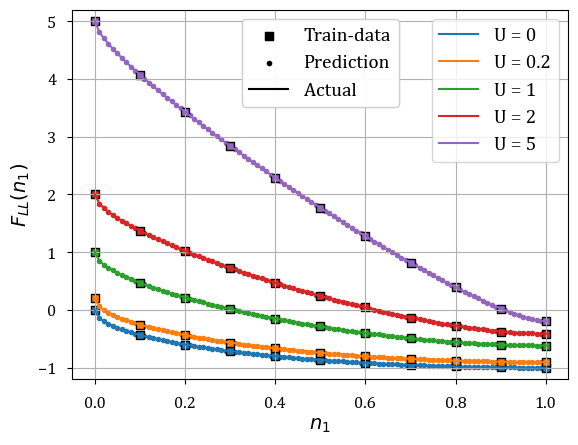

In [775]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.xlim(-0.05, 1.05)
plt.ylim(-1.2, 5.2)
plt.grid(True)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)

plots = []
for i in range(len(U_list)):
    plot, = plt.plot(n_array, functionals[i], label=f'U = {U_list[i]}')  # Add a comma to unpack the returned list
    plots.append(plot)
    plt.scatter(n_array[test_indices], functionals_pred_list[i], c=colours[i], marker='.')
    plt.scatter(n_array[train_indices], functionals[i][train_indices], marker='s', edgecolors='black')

# Add legend for U values
legend1 = plt.legend(handles=plots, loc='upper right', prop={'size': 14})
plt.gca().add_artist(legend1)

# Add legend for markers
marker1 = plt.scatter([], [], marker='s', c='black', label='Train-data')
marker2 = plt.scatter([], [], marker='.', c='black', label='Prediction')
marker3, = plt.plot([], [], c='black', label='Actual')
legend2 = plt.legend(handles=[marker1, marker2, marker3], loc=9,
                     prop={'size':14})
plt.gca().add_artist(legend2)

We will plot the absolute error of our learning task with respect to $n_{1}$. 

We will investigate the relationship between the number of training points on the root mean square error. We will compare the results generated by the Levy-Lieb kernel to the results generated by the Gaussian kernel.

In [948]:
RMSE_LevyLieb_list = []
RMSE_Gaussian_list = []

U_list = [0, 0.2, 1, 2, 5]

alpha = 1e-5
training_size_list = np.arange(2, 19, 1)

for i, U in enumerate(U_list):
    rmse_LL = []
    rmse_G = []

    for N in training_size_list:
        # Perform train-test split
        train_indices = np.linspace(0, len(n_array) - 1, N, dtype=int)
        rest_indices = [i for i in range(len(n_array)) if i not in train_indices]

        # Test set is equal to one third of remaining density values
        np.random.shuffle(rest_indices)
        test_indices = rest_indices[: len(n_array) // 10]

        functionals_train = functionals[i][train_indices]
        functionals_test = functionals[i][test_indices]

        # Generate training and testing kernels
        n_train = n_array[train_indices]
        K_train = np.array([[K_total[i, j] for j in train_indices] for i in train_indices])
        K_test = np.array([[K_total[i, j] for j in train_indices] for i in test_indices])

        # Fit Kernel Ridge model with Levy-Lieb kernel matrices
        model_LL = KernelRidge(alpha=alpha, kernel='precomputed')
        model_LL.fit(K_train, functionals_train)
        functionals_pred_LL = model_LL.predict(K_test)

        # Construct kernel ridge model with Gaussian kernel
        opt_gamma = optimum_gamma(K_train, n_train)
        model_G = KernelRidge(alpha=alpha, kernel='rbf', gamma=opt_gamma)
        model_G.fit(n_train.reshape(-1, 1), functionals_train)
        functionals_pred_G = model_G.predict(n_array[test_indices].reshape(-1, 1))

        # Compile root mean squared error for each value of U
        rmse_LL.append(root_mean_squared_error(functionals_test, functionals_pred_LL))
        rmse_G.append(root_mean_squared_error(functionals_test, functionals_pred_G))

    RMSE_LevyLieb_list.append(rmse_LL)
    RMSE_Gaussian_list.append(rmse_G)

As can be seen above, the training curve for the Gaussian kernel was found to converge to $10^{-2}$, while the RMSE for the Levy-lieb kernel could reach $10^{-7}$. 

Now we will perform an out-distribution learning task (L2), where our training set will be evenly sampled $0.5 \leq n_1 \leq 1$ only.

In [842]:
def optimum_gamma(K_LevyLieb, n_train):
    """Calculates the optimum choice for Gaussian hyperparameter for training set and U
    by maximising the kernel alignment between the Levy-Lieb & Gaussian kernels."""
    def alignment(gamma):
        K_G = kernel_gaussian(n_train, n_train, gamma)
        return np.trace(K_G @ K_LevyLieb) / (np.sqrt(np.trace(K_G @ K_G) * np.trace(K_LevyLieb @ K_LevyLieb)))
    
    gamma_opt = minimize(fun=lambda gamma: -alignment(gamma), 
                         method='SLSQP', 
                         bounds=[(0, None)],
                         constraints={'type': 'ineq', 'fun': lambda gamma : gamma},
                         x0=1,
                         )
    return gamma_opt.x[0]

In [ ]:
from sklearn.metrics import mean_squared_error

# Train test split
train_indices = np.arange(len(n_array) // 2, functionals.shape[1], 4)
test_indices = [index for index in range(len(n_array)) if index not in train_indices]

# Evaluate Levy Lieb kernel for train and test sets, for each U
functionals_pred_list = []

for i in range(len(U_list)):
    # Training set
    n_train = n_array[train_indices]
    functionals_train = functionals[i][train_indices]

    # Calculate train and test kernel matrices
    K_total = total_kernels_list[i]
    K_train = np.array([[K_total[i, j] for j in train_indices] for i in train_indices])
    K_test = np.array([[K_total[i, j] for j in train_indices] for i in test_indices])

    opt_gamma = optimum_gamma(K_train, n_train)

    # Define Kernel ridge regression model and calculate predictions
    model = KernelRidge(alpha=1e-10, kernel='precomputed')
    model.fit(K_train, functionals_train)
    functionals_pred = model.predict(K_test)
    functionals_pred_list.append(functionals_pred)

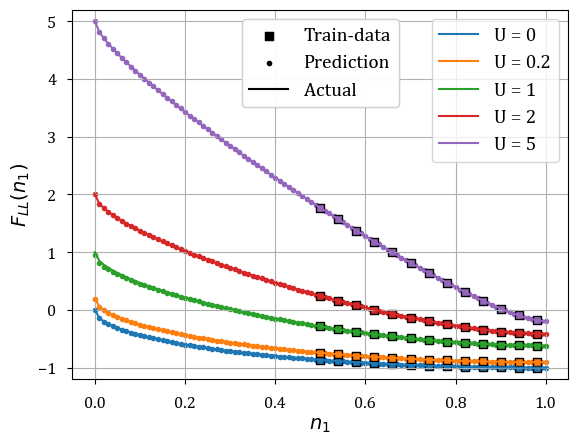

In [865]:
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.xlim(-0.05, 1.05)
plt.ylim(-1.2, 5.2)
plt.grid(True)
plt.xlabel('$n_{1}$', fontdict={'fontsize': 14})
plt.ylabel('$F_{LL}(n_{1})$', fontdict={'fontsize': 14})
plt.tick_params(axis='both', labelsize=12,  direction='out', pad=8)

plots = []
for i in range(len(U_list)):
    plot, = plt.plot(n_array, functionals[i], label=f'U = {U_list[i]}')
    plots.append(plot)
    plt.scatter(n_array[test_indices], functionals_pred_list[i], c=colours[i], marker='.')
    plt.scatter(n_array[train_indices], functionals[i][train_indices], marker='s', edgecolors='black')

# Add legend for U values
legend1 = plt.legend(handles=plots, loc='upper right', prop={'size': 14})
plt.gca().add_artist(legend1)

# Add legend for markers
marker1 = plt.scatter([], [], marker='s', c='black', label='Train-data')
marker2 = plt.scatter([], [], marker='.', c='black', label='Prediction')
marker3, = plt.plot([], [], c='black', label='Actual')
legend2 = plt.legend(handles=[marker1, marker2, marker3], loc=9,
                     prop={'size':14})
plt.gca().add_artist(legend2)

## References
1. C. D. Pemmaraju and A. Deshmukh, “Levy-lieb embedding of density-functional theory and its quantum kernel: Illustration for the hubbard dimer using near-term quantum algorithms,” Physical Review A, vol. 106, no. 4, 2022. doi:10.1103/physreva.106.042807.

2. D. J. Carrascal, J. Ferrer, J. C. Smith, and K. Burke, “The Hubbard Dimer: A density functional case study of a many-body problem,” Journal of Physics: Condensed Matter, vol. 27, no. 39, p. 393001, Sep. 2015. doi:10.1088/0953-8984/27/39/393001 